# Практическое ДЗ 3

# Задача 1. Томография (40 баллов)

В этом задании мы попробуем построить томограмму некоторого объекта, пользуясь данными об интенсивности лучей, прошедших через него.

In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.sparse as sparse
import scipy.sparse.linalg as spla
import scipy as sp
from scipy import signal


### Генерация данных

Загрузим сечение анализируемой структуры из файла (скачать данные можно по [ссылке](https://disk.yandex.ru/d/d3yQWn9gPD7lJw)). Можно представлять, что мы анализируем, например, альвеолы в лёгких. Или колонию клеток.

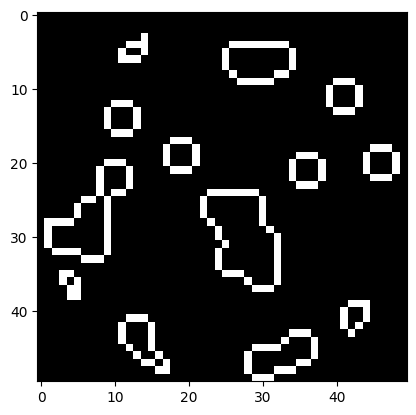

In [46]:
data = np.load("data/tomography.npy")
plt.imshow(data, cmap="gray")
n = data.shape[0]
assert (n, n) == data.shape

Томограф работает так: лучи испускаются из источника, проходят через анализируемую структуру и попадают на детектор (посмотрите картинки по [ссылке](https://plus.maths.org/content/saving-lives-mathematics-tomography)). По интенсивности луча, пришедшего в детектор можно понять, сколько энергии было поглощено по пути. В этой задаче мы будем считать, что количество поглощённой энергии пропорционально количеству пересечённых белых пикселей.

Мы хотим научиться считать величину $p_{\alpha, y}$ &mdash; количество белых пикселей, пересечённых прямой с заданным углом наклона $\alpha$ и проходящих через точку с координатой $(0, y)$ (оси $x,y$ проходят через центр картинки).


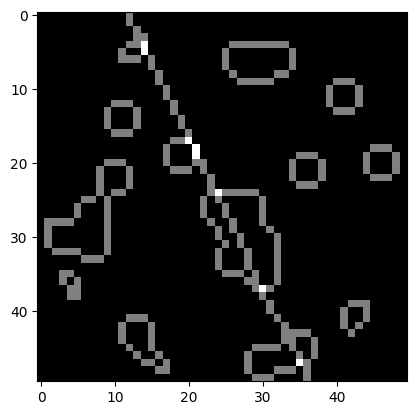

In [47]:
line = np.zeros((n,n))
I = np.arange(n)
J = (I * np.sin(np.pi/6) + n//4).astype(int)
mask = (J >= 0) & (J < n)
line[I[mask], J[mask]] = 1
_ = plt.imshow(data + line, cmap="gray")

Но делать это вычисление мы хотим одновременно для набора углов $\{\alpha_1, \dots, \alpha_s\}$ и набора координат $\{y_1, \dots, y_t\}$. Поэтому мы сформируем матрицу $P$ размера $st \times n^2$, которая при умножении на вытянутую в столбец картинку `data` даст столбец, состоящий из величин $p_{\alpha_i, y_j}$.

Систему координат мы разместим в центре картинки, ось X направим вправо, ось Y вверх. Таким, образом, точка $(x,y)$ примерно соответствует пикселю `data[n//2 - y, x + n//2]`. Реализуем функцию `build_projection_operator`, возвращающую матрицу $P$.

In [48]:
def build_projection_operator(n, alphas, ys):
    P = np.zeros((len(alphas) * len(ys), n**2))
    index = 0
    for alpha in alphas:
        tan = np.tan(alpha)
        cotan = np.tan(np.pi/2 - alpha)
        for y0 in ys:
            if np.abs(tan) <= 1:
                X = np.arange(-n//2, n//2)
                Y = y0 + X * tan
                mask = (Y > -n/2.) & (Y < n/2.)
            else:
                Y = np.arange(-n//2, n//2)
                X = (Y - y0) * cotan
                mask = (X > -n/2.) & (X < n/2.)
            X = np.clip(X + n//2, 0, n - 1)
            Y = np.clip(n//2 - Y, 0, n - 1)
            I = Y[mask].astype(np.int64)
            J = X[mask].astype(np.int64)
            P[index, I + J * n] = 1
            index += 1
    return P

In [49]:
n_alphas = 20
n_ys = 64
alphas = np.linspace(0, np.pi, num=n_alphas, endpoint=False)
ys = np.linspace(-n/2., n/2., num=n_ys)
P = build_projection_operator(n, alphas, ys)
P.shape

(1280, 2500)

Выведем несколько строк матрицы `P` в виде картинок и убедимся, что они соответствуют лучам томографа.

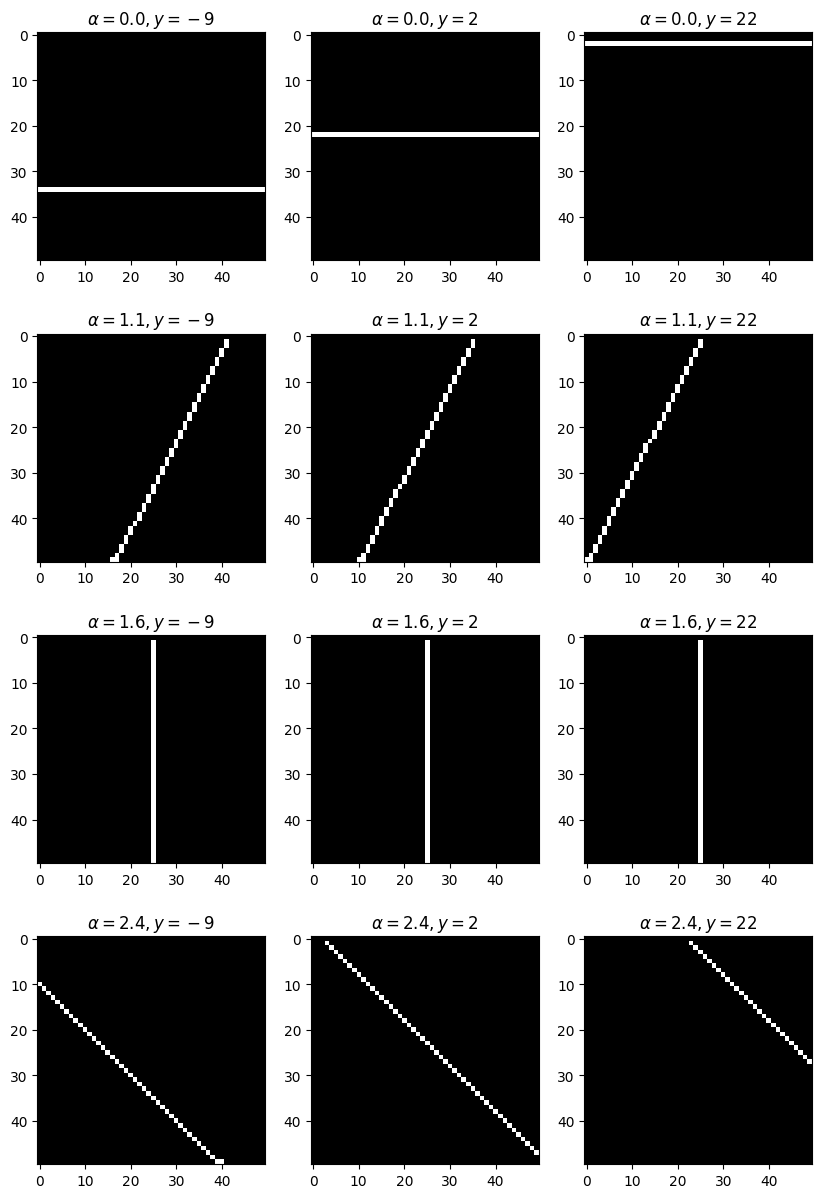

In [50]:
fig, axs = plt.subplots(4, 3, figsize=(10, 15))
for i, i_alpha in enumerate([0, 7, 10, 15]):
    for j, i_y in enumerate([20, 35, 60]):
        axs[i,j].imshow(np.reshape(P[i_y +  i_alpha * n_ys, :], (n, n)).T, cmap="gray")
        axs[i,j].set_title("$\\alpha = {:.2}, y = {}$".format(alphas[i_alpha], int(ys[i_y])))

  1. **(4 балла)** Сформируйте проекцию, используя матрицу $P$ и исходную картинку `data`. При вытягивании картинки в столбец используйте такое значение параметра `order`, чтобы этот процесс соответствовал векторизации с лекции.

In [51]:
projection = P @ data.flatten(order='f')

Порешейпим проекцию так, чтобы строки соответствовали углам $\alpha_i$, а столбцы &mdash; сдвигам $y_j$.

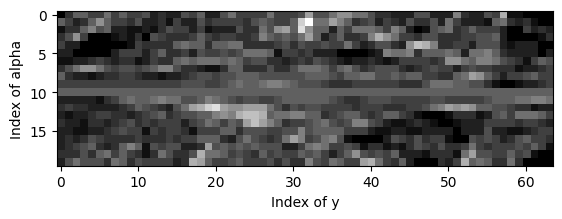

In [52]:
plt.imshow(np.reshape(projection, (n_ys, n_alphas), order="f").T, cmap="gray")
plt.xlabel("Index of y")
_ = plt.ylabel("Index of alpha")

   2. **(По желанию)** Попробуйте объяснить одноцветную линию, соответствующую углу $\alpha = \frac{\pi}{2}$ (горизонтальная линия в середине последнего графика).

$p_{\alpha, y}$ &mdash; количество белых пикселей, пересечённых прямой с заданным углом наклона $\alpha$ и проходящих через точку с координатой $(0, y)$. В случае $\alpha=\pi/2$ прямая при любых $y$ будет совпадать с осью оридинат, то есть  $\forall y\; p_{\pi/2, y} = \text{const}(\pi/2)$.

### Получение томограммы по проекции

Для восстановления исходной структуры по проекциям, необходимо решить уравнение $Px = b$, где столбец $b$ содержит проекции.
Так как матрица $P$ имеет больше столбцов, чем строк, то система является **недоопределённой**, то есть одни и те же проекции могло дать бесконечно большое количество исходных структур $x$. Если же мы наложим дополнительное требование, чтобы 2-норма вектора $x$ была минимальна, то полученная задача
$$
\|x\|_2 \to \min_{Px=b}
$$
имеет известное решение $x = P^+b$. Поэтому в данном разделе вам необходимо найти псевдообратную матрицу к $P$. Так как в вычислениях с плавающей точкой задача нахождения псевдообратной является некорректно поставленной (из-за того, что сравнение сингулярных чисел с нулём не имеет смысла), то на практике обычно вычисляют $\delta$-псевдообратные матрицы. При их вычислении отбрасываются все сингулярные числа, меньшие $\delta$. Полученная матрица обозначается $P^+_\delta$.

Если исходная матрица имеет много малых сингулярных чисел, то имеет смысл не вычислять $P^+_\delta$ в явном виде, а использовать для вычислений компактное SVD этой матрицы, то есть разложение, в котором матрицы $U$ и $V$ имеют по $\mathrm{rank}(P^+_\delta)$ столбцов. Мы так и поступим.

   3. **(10 баллов)** Напишите функцию `pseudoinverse`, вычисляющую для заданной матрицы $P$ сингулярное разложение её $\delta$-псевдообратной.
Необходимо вернуть компактное SVD матрицы $P^+_\delta$.
Для вычисления используйте сингулярное разложение матрицы $P$. Использовать функцию `np.linalg.pinv` запрещено.

In [53]:
def pseudoinverse_svd(A: np.ndarray, threshold: float = 1e-15) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Input
            A: m x n array
            threshold: smaller singular values are to be dropped
        Output
            U: n x r array with orthonormal columns
            S: array of size r
            VT: r x m array with orthonormal rows
    """
    U, S, VT = np.linalg.svd(A, full_matrices=False)
    r = np.sum(S >= threshold)
    S_p = 1/S[:r]
    U_p = VT[:r, :].T
    VT_p = U[:, :r].T
    
    return U_p, S_p, VT_p

Проверим, что псевдообратная совпадает с обратной для квадратной невырожденной матрицы $A$ (случайная матрица с вероятностью, очень близкой к единице, является невырожденной).

In [54]:
A = np.random.random((3, 3))
U, S, VT = pseudoinverse_svd(A)
pinv = np.multiply(U, S) @ VT
assert np.linalg.norm(pinv @ A - np.eye(3)) < 1e-12

   4. **(6 баллов)** С помощью сингулярного разложения $\delta$-псевдообратной к $P$ и вектора `projection` восстановите изображение. Для получения полного балла сложность вычисления восстановленного изображения (без учета SVD) должна быть $O(n^2r + r st)$, где $r = \mathrm{rank}(P^+_\delta)$. Иными словами, нельзя формировать полную матрицу $P^+_\delta$. **Обратите внимание:** дефолтное значение параметра `threshold` не очень подходит для данной задачи, вместо этого рекомендуем использовать `threshold=1`.

In [55]:
U_p_pinv, S_p_pinv, VT_p_pinv = pseudoinverse_svd(P, threshold=1.)

reconstructed_pinv = U_p_pinv @ (S_p_pinv * (VT_p_pinv @ projection))

# eqiuvalent to:
# reconstructed_pinv = np.einsum('ij,j,jk,k->i', U_p_pinv, S_p_pinv, VT_p_pinv, projection, optimize='optimal')

Проверьте своё решение: убедитесь, что $\frac{\|P x_{reconstructed} - b\|_2}{\|b\|_2}$ не очень велико, а также выведите в виде изображения вектор `reconstructed_pinv`. На картинке должны достаточно чётко виднеться контуры объектов, особенно близких к центру (**опционально**: можете ли вы неформально объяснить тот эффект, что лучше восстанавливаются объекты, более близкие к центру?)

In [56]:
assert np.linalg.norm(P @ reconstructed_pinv - projection) / np.linalg.norm(projection) < 1e-2

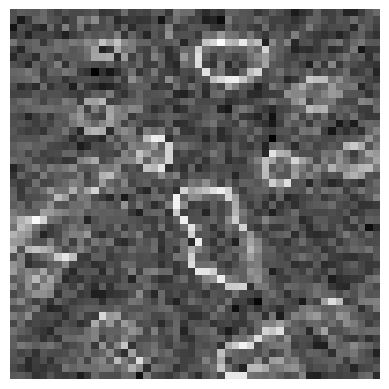

In [57]:
plt.imshow(reconstructed_pinv.reshape(n, n, order='f'), cmap="gray"); _ = plt.axis('off')

### Ridge regression

Теперь попробуем подойти к восстановлению изображения с другой стороны: будем решать при фиксированном $\mu > 0$ так называемую $\ell_2$-регуляризованную задачу наименьших квадратов (в англоязычной литературе ridge regression):
$$
\|Px - b\|_2^2 + \mu \|x\|_2^2 \to \min
$$
($b$ здесь означает вектор `projection`).
Смысл состоит в том, что мы хотим, чтобы одновременно и $x$ давала проекцию, похожую на $b$, и при этом сам вектор $x$ не был слишком велик по норме.

Для решения этой задачи запишем условие равенства нулю градиента этой функции:
$$
2(Px-b)^\top P + 2\mu x^\top = 0 \Leftrightarrow (P^\top P + \mu I)x = P^\top b.
$$

   5. **(12 баллов)** Используя компактное SVD $P$, напишите тело функции `ridge_regression`, решающую указанную задачу минимизации для заданных $P$, $b$ и $\mu$. Для получения полного балла не формируйте нигде матриц размером $n^2 \times n^2$.

In [58]:
def ridge_regression(P, b, mu):
    """
        Input
            P: m x n numpy array
            b: numpy array of size m
            mu: regularization coefficient

        Output
            x: numpy array of size n solving ridge regression problem
    """
    _, S, VT = np.linalg.svd(P, full_matrices=False)
    
    x = VT.T @ ((S[:, None]**2 + mu)**(-1) * VT @ P.T @ b)
    
    return x

In [59]:
reconstructed_ridge = ridge_regression(P, projection, 1)

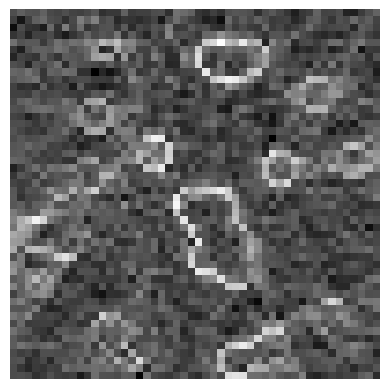

In [60]:
plt.imshow(reconstructed_ridge.reshape(n, n, order='f'), cmap="gray"); _ = plt.axis('off')

Обратите внимание, насколько похож результат решения задачи ridge regression на решение с помощью псевдообратной. Это неслучайно: можно показать, что эти два подхода тесно взаимосвязаны, а в пределе при $\mu, \delta \to 0$ дают одинаковые векторы.

### Lasso

Если в ridge regression вместо квадрата второй нормы $x$ использовать первую норму (то есть ставить $\ell_1$-регуляризованную задачу наименьших квадратов), то получится такая задача минимизации:
$$
\|Px-b\|_2^2 + \mu \|x\|_1 \to \min.
$$

Такая задача оказывается более подходящей в нашем случае, так как её решение часто оказывается разреженным (получить некоторую интуицию о том, почему так происходит, можно, например, [тут](https://medium.com/analytics-vidhya/intuition-behind-l1-l2-regularisation-2ac1e6a1bd81); более развёрнутое описание метода есть в [википедии](https://en.wikipedia.org/wiki/Lasso_(statistics))).

   6. **(8 баллов)** Заполните пропуски в теле функции `solve_lasso`. Воспользуйтесь документацией к классу [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).


In [61]:
from sklearn.linear_model import Lasso

def solve_lasso(P, b):
    lasso = Lasso(alpha=0.001, fit_intercept=False)
    lasso.fit(P, b)
    
    return lasso.coef_

In [62]:
reconstructed_lasso = solve_lasso(P, projection)

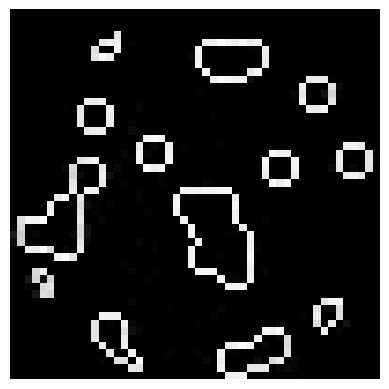

In [63]:
plt.imshow(reconstructed_lasso.reshape(n, n, order='f'), cmap='gray'); _ = plt.axis('off')

Сравним все три полученных решения с исходной структурой.

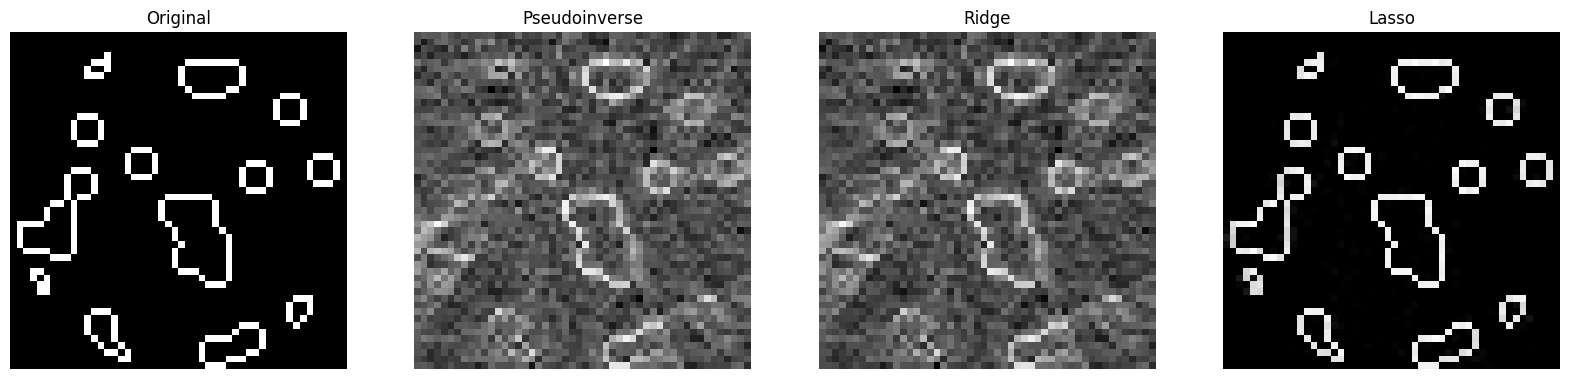

In [64]:
fig, axs = plt.subplots(1,4, figsize=(20,30))
for i, (im, name) in enumerate([
    (data, "Original"),
    (reconstructed_pinv.reshape(n, n, order='f'), "Pseudoinverse"),
    (reconstructed_ridge.reshape(n, n, order='f'), "Ridge"),
    (reconstructed_lasso.reshape(n, n, order='f'), "Lasso"),
]):
    axs[i].imshow(im, cmap="gray")
    axs[i].set_title(name)
    axs[i].axis('off')

# Задача 2. Быстрое вычисление дискретной свертки (60 баллов)

В этой задаче мы научимся эффективно вычислять **свёртку** изображения на примере одного из самых известных фильтров &mdash; фильтра Гаусса (подзадачи a., b., c.), а также попробуем восстановить исходное изображение из размытого (подзадача d.).

**Обратите внимание:** <font color='red'>во всех пунктах данной (и бонусной) задачи запрещается использовать циклы.</font>

Начнем с эффективного применение фильтра Гаусса

Загрузим изображение (в виде матрицы $A$), с которым будем работать. Будем использовать одну из классических фотографий, применяемых для тестирования алгоритмов обработки изображений: "cameraman". 

(256, 256)


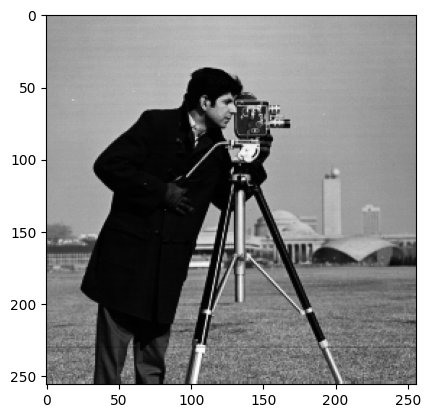

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

A = imread('data/cameraman.tif').astype(float)
print(A.shape)
_ = plt.imshow(A, cmap='gray')

Мы будем учиться применять к картинке [фильтр Гаусса](https://en.wikipedia.org/wiki/Gaussian_blur), чтобы получить в итоге что-то вроде следующего изображения. 

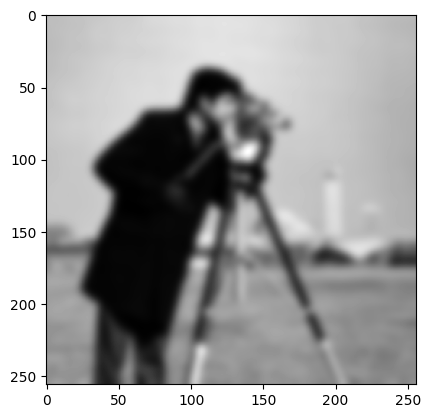

In [66]:
from scipy.ndimage import gaussian_filter
B = gaussian_filter(A, 3)
_ = plt.imshow(B, cmap='gray')

### a. (12 баллов) Формулировка задачи

При это преобразовании каждый пиксель картинки заменяется на взвешенную сумму соседних пикселей (вообще говоря, всех остальных пикселей картинки), причём вес пикселя со смещением $\Delta x$ и $\Delta y$ относительно данного есть
$$
G(\Delta x, \Delta y) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{\Delta x^2 + \Delta y^2}{2\sigma^2}\right).
$$
Это называется двумерной **свёрткой** картинки с фильтром Гаусса (обычно при этом считается, что картинка продолжена за края каким-то образом, например, отражена, чтобы пиксели размытой картинки у краёв не имели меньшую яркость. Но мы не будем реализовывать этот эффект).

 1. **(12 баллов)** Покажите, что результат $B$ применения такой операции к матрице $A$ можно представить в виде
$$
    B = T_m A T_n^T,
$$
где 
$$
(T_n)_{i,j} = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(i-j)^2}{2\sigma^2}\right).
$$

**Замечание:** формулу для $B$ можно будет использовать в дальнейшем даже если этот пункт не был решен.


$\square$ С одной стороны:

$
B_{pq} = \dfrac{1}{2\pi \sigma^2} \sum\limits_{i=1}^{n}\sum\limits_{j=1}^{m} A_{ij} \exp\left[ -\dfrac{(i - p)^2 + (j - q)^2}{2\sigma^2} \right].
$

С другой стороны:

$
(T_m A T_n^T)_{pq} = 
\sum\limits_{j=1}^{n} \left(\sum\limits_{i=1}^{m} A_{ij} (T_m)_{pi} \right) (T_n)_{qj} =
\dfrac{1}{2\pi\sigma^2} \sum\limits_{j=1}^{n} \left(\sum\limits_{i=1}^{m} A_{ij} \exp\left[ -\dfrac{(p-i)^2}{2\sigma^2} \right] \right) \exp\left[ -\dfrac{(q - j)^2}{2\sigma^2} \right] = 
B_{pq}.
$
$\blacksquare$


### b. (26 баллов) Имплементация одномерных сверток

1. **(17 баллов)** Реализуйте функцию `convolve_1D`, которая вычисляет $T_m A$ с помощью вложения $T_m$ в циркулянт и использования быстрого преобразования Фурье (```np.fft.fft```). Матрица $T_m$ задаётся с помощью своего первого столбца. При вычислениях нигде не должна возникнуть полная матрица $T_m$.

In [67]:
def convolve_1D(A, T_col):
    """
        Input
            A: m x n matrix
            T_col: array of shape (m,) -- first column of matrix T_m

        Output
            B: m x n matrix, B = T_m @ A
    """
    m = A.shape[0]
    c = np.concatenate((T_col, T_col[:0:-1]))  # T_m is toeplitz and symmetric
    
    return np.fft.ifft(np.fft.fft(c)[:, None] * np.fft.fft(A, n=2*m-1, axis=0), axis=0)[:m].real  # we know that result must be real-valued

Напишем также функцию `form_T_col`, которая будет создавать первый столбец матрицы `T_m` для заданных параметров `m` и `sigma`, а также `form_T`, которая будет создавать собственно матрицу $T_m$. Мы будем использовать `form_T` для тестирования правильности вычислений.

In [68]:
from scipy.linalg import toeplitz

def form_T_col(m, sigma):
    """
        Input
            m: number of rows of T_m
            sigma: standard deviation of Gaussian filter

        Output
            T_col: array of shape (m,) -- first column of T_m, 
                   the matrix of 1D Gaussian filter
    """
    return 1. / (np.sqrt(2 * np.pi) * sigma) * np.exp((-1. / (2 * sigma**2)) * np.arange(m)**2)
    
def form_T(m, sigma):
    """
        Input
            m: number of rows of T_m
            sigma: standard deviation of Gaussian filter

        Output
            T_m: m x m matrix of 1D gaussian filter
    """
    return toeplitz(form_T_col(m, sigma))

Теперь мы можем проверить, правильно ли работает функция `convolve_1D`.

In [69]:
B = A[:5,:5]
sigma = 10
m, n = B.shape
T_m_col = form_T_col(m, sigma)
T_m = form_T(m, sigma)
np.linalg.norm(T_m @ B - convolve_1D(B, T_m_col))

np.float64(3.370400129833633e-14)

2. **(2 балла)** Используя тот факт, что быстрое преобразование Фурье вектора длины $n$ вычисляется за $O(n\log n)$, выпишите асимптотику времени работы функции `convolve_1D`.

Вектор $c$ формируется из $T_{\text{col}}$ за $O(m)$. БПФ от вектора $c$, вектор $\hat{c}$, находится за $O(m\log m)$. БПФ от стобцов матрицы $A\in\mathbb{R}^{m\times n}$, к которым были добавлены $m-1$ ноль в конце, находится суммарно за $O(n m\log m)$. Перемножение вектора $\hat{c}$ на все столбцы преобразованной матрицы происходит за $O(mn)$. В конце находится ОБПФ от стобцов матрицы размера $2m -1$ на $n$, которое может быть посчитано за $O(nm \log m)$. Таким образом, общая сложность алгоритма равна $O(nm \log m)$.

3. **(5 балла)** Теперь нам понадобится функция `gauss_convolve_1D`, которая сформирует правильный столбец `T_col` и вызовет `convolve_1D`. Параметр `sigma` соответствует гауссовскому стандартному отклонению $\sigma$ из формулы для $G(\cdot)$.

In [70]:
def gauss_convolve_1D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            B: m x n matrix, B = T_m @ A
    """
    T_col = form_T_col(A.shape[0], sigma)
    B = convolve_1D(A, T_col)
    
    return B

4. **(2 балла)** Проверим, как работает наша одномерная свёртка на нашей картинке. Должно быть похоже, что каждый столбец размыли. Когда всё получится, попробуйте поиграть параметром `sigma` и объясните, как от него зависит "сила" размытия.

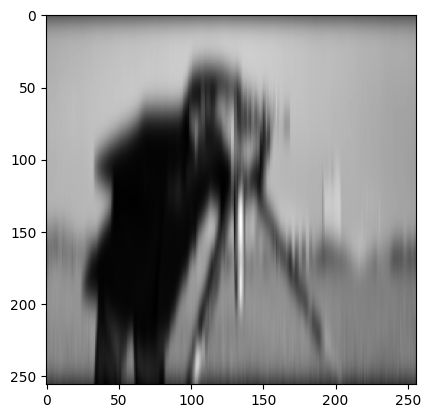

In [71]:
A_conv_1D = gauss_convolve_1D(A, 10)
_ = plt.imshow(A_conv_1D, cmap='gray')

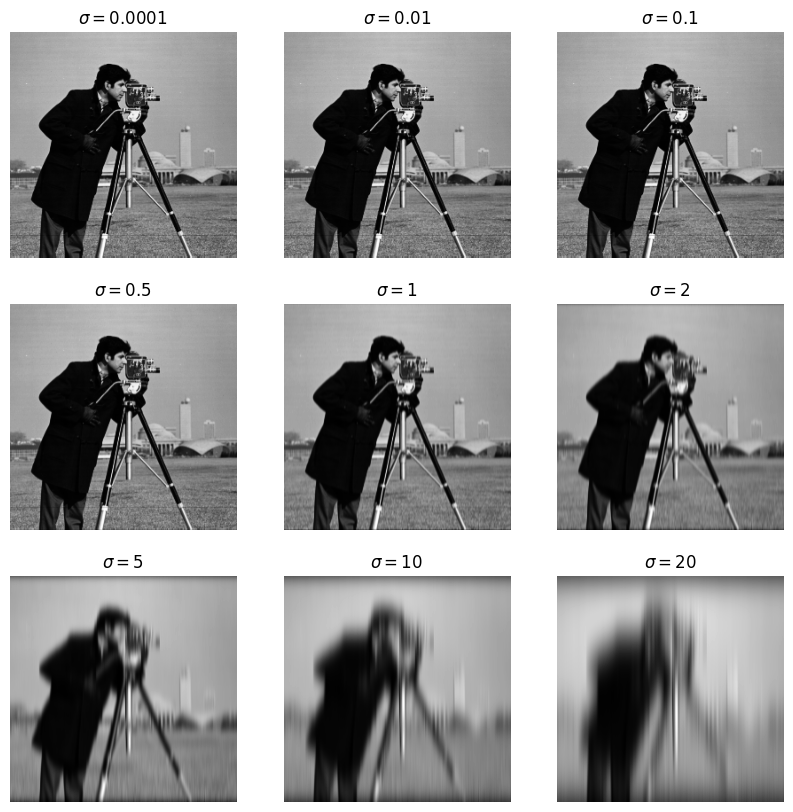

In [72]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
sigmas = [1e-4, 1e-2, 1e-1, 0.5, 1, 2, 5, 10, 20]
for ax, sigma in zip(axs, sigmas):
    A_conv_1D = gauss_convolve_1D(A, sigma)
    ax.imshow(A_conv_1D, cmap='gray')
    ax.set_title(rf'$\sigma={sigma}$')
    ax.set_axis_off()

При увеличении $\sigma$ увеличивается "эффективное" число пикселей, с которыми взвешенно суммируется каждый пиксель. У полученного фильтра низких частот частота среза уменьшается, что приводит к более сильному размытию картинки (по вертикали). Можно видеть, что для $\sigma \ll 1$ картинка визуально не отличается от исходной, при $\sigma \sim 1$ размытие становится заметным, а при $\sigma \gg 1$ сначала становится невозможным увидеть детали, а потом и вовсе понять, что изображено на картинке.

### c. (10 баллов) Вычисление двумерной свертки

1. **(8 баллов)** Теперь вы уже без труда сможете написать функцию двумерной свёртки: $B = T_m A T_n^T$, используя функцию ```gauss_convolve_1D```.

In [73]:
def gauss_convolve_2D(A, sigma):
    """
        Input
            A: m x n matrix
            sigma: standard deviation of Gaussian filter

        Output
            С: m x n matrix, B = T_m @ A @ T_n.T
    """
    B = gauss_convolve_1D(A, sigma)
    C = gauss_convolve_1D(B.T, sigma).T
    
    return C

...и визуально проверить, правильно ли она работает.

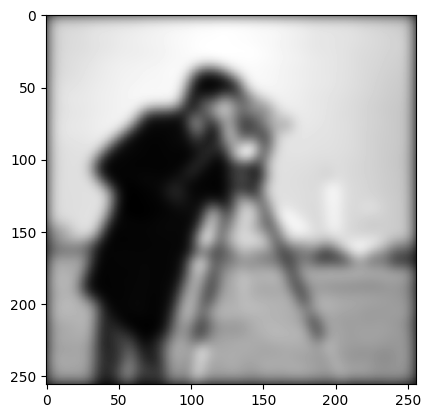

In [74]:
A_conv = gauss_convolve_2D(A, 5)
_ = plt.imshow(A_conv, cmap='gray')

2. **(2 балла)** Объясните эффект тёмных полос около края картинки.

Черные полосы связаны с тем, что при вычислении сверток использовалось заполнение нулями краев картинки (zero-padding). Поэтому при вычислении значений сверток на краях и в углу картинки суммируется меньшеее число ненулевых слагаемых, что приводит к характерной темной рамке на краях картинки.

### d. (12 баллов) Обращение свёртки (deconvolution)

Представьте, что к вам попало изображение такого типа. (Заодно оцените на похожесть вашего фильтра со стандратным фильтром из `SciPy`).

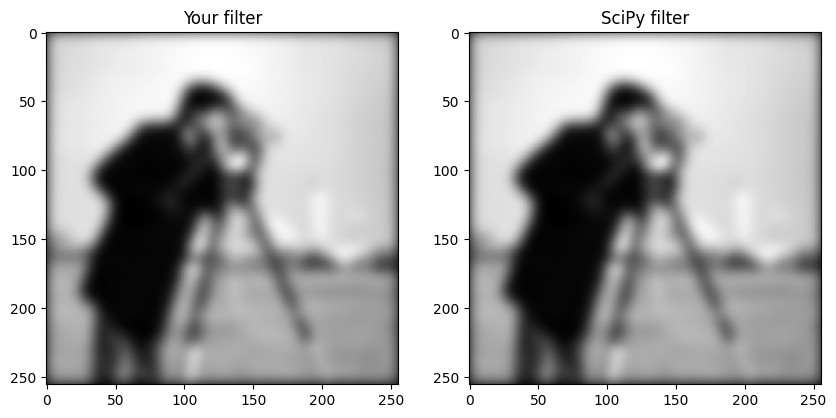

In [75]:
from scipy.ndimage import gaussian_filter
sigma = 5
A_conv = gauss_convolve_2D(A, sigma)
A_conv_scipy = gaussian_filter(A, sigma, mode='constant')
fig = plt.figure(figsize=(10, 7)) 
rows, columns = 1, 2
fig.add_subplot(rows, columns, 1) 
plt.imshow(A_conv.real, cmap='gray')
plt.title('Your filter')
fig.add_subplot(rows, columns, 2) 
plt.imshow(A_conv_scipy.real, cmap='gray')
plt.title('SciPy filter')
plt.show()

Деталей не видно совсем. Чтобы восстановить их попробуем применить применить операцию обратную свертке. 
Мы уже знаем, что размытое изображение $A_{conv}$ вычисляется по формуле $A_{conv} = T_m A T_n^\top$.
Если же матрицы $T_m$ и $T_n$ обратимы, то можно обратить свёртку и получить обратно нашего cameraman:
$$
A = T_m^{-1} A_{conv} T_n^{-\top}.
$$

In [76]:
m, n = A_conv.shape
T_m, T_n = form_T(m, sigma), form_T(n, sigma)
B = np.linalg.solve(T_m, A_conv)
A_rec = np.linalg.solve(T_n, B.T).T

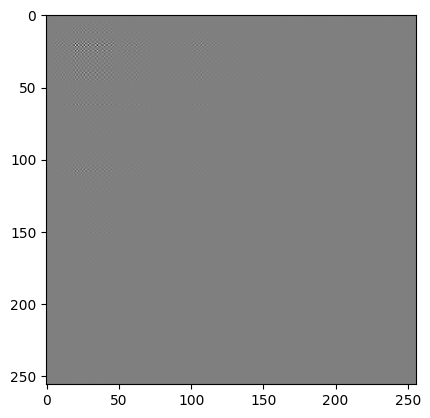

In [77]:
_ = plt.imshow(A_rec, cmap='gray')

Непохоже на исходное изображение. В чём может быть дело?
Давайте выведем сингулярные числа матрицы $G_m$.

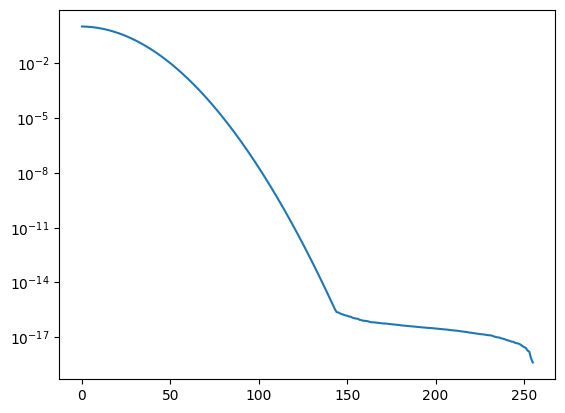

In [78]:
s = np.linalg.svd(T_m, compute_uv=False)
plt.plot(s)
_ = plt.semilogy()

Видно, что у нас большие проблемы (хотя пока мы не умеем это формализовывать), потому что матрица очень близка к вырожденной. Специально для таких матриц у нас есть инструмент псевдообратных матриц, но чтобы оправдать его применение, нужно сначала свести задачу вычисления матрицы $A$ к задаче решения системы линейных уравнений. 
Для этого вспомним формулу, связанную с Кронекеровым произведением: 
$$
\mathrm{vec}(A_{conv}) = (T_n \otimes T_m)\,\mathrm{vec}(A).
$$
Теперь уже можно вычислить "приближённый" $\mathrm{vec}(A)$ с помощью псевдообратных:
$$
\mathrm{vec}(\tilde{A}) = (T_n \otimes T_m)^+ \,\mathrm{vec}(A_{conv})
$$

Конечно, мы не хотим формировать матрицу размеров $mn \times mn$ и работать с ней, поэтому воспользуемся (проверьте) тем фактом, что
$$
(T_n \otimes T_m)^+ = T_n^+ \otimes T_m^+.
$$
Теперь можно перейти обратно к матричной записи: 
$$
\tilde{A} = T_m^+ A_{conv} (T_n^+)^\top.
$$

1. **(12 баллов)** Реализуйте функцию ```inverse_gauss_convolve_2D```, которая реконструирует изображение по "смазанной" картинке $A_{conv}$ с помощью псевдообратных матриц от матриц $T_m$ и $T_n$, у которых занулили сингулярные числа меньше ```tol```. **Замечание:** В данном случае ```np.linalg.pinv``` выдаст всю псевдообратную матрицу, что подойдет в качестве решения. Но можно сделать немного эффективнее, если явно умножать на компоненты компактного SVD.

In [79]:
def inverse_gauss_convolve_2D(A_conv, sigma, tol):
    """
        Input
            conv: m x n matrix -- result of convolution with
                  a Gaussian filter
            sigma: standard deviation of Gaussian filter
            tol: absolute tolerance for cutting singular values in pseudoinverse

        Output
            A_rec: m x n reconstructed matrix, such that approximately A_conv = T_m @ A_rec @ T_n.T
    """
    m, n = A_conv.shape
    
    Um, Sm, VmT = pseudoinverse_svd(form_T(m, sigma), threshold=tol)
    Un, Sn, VnT = pseudoinverse_svd(form_T(n, sigma), threshold=tol)
    
    return np.einsum('ab,b,bc, cd, de,e,eg -> ag', Um, Sm, VmT, A_conv, VnT.T, Sn, Un.T, optimize='optimal')

Посмотрим на получившийся результат.

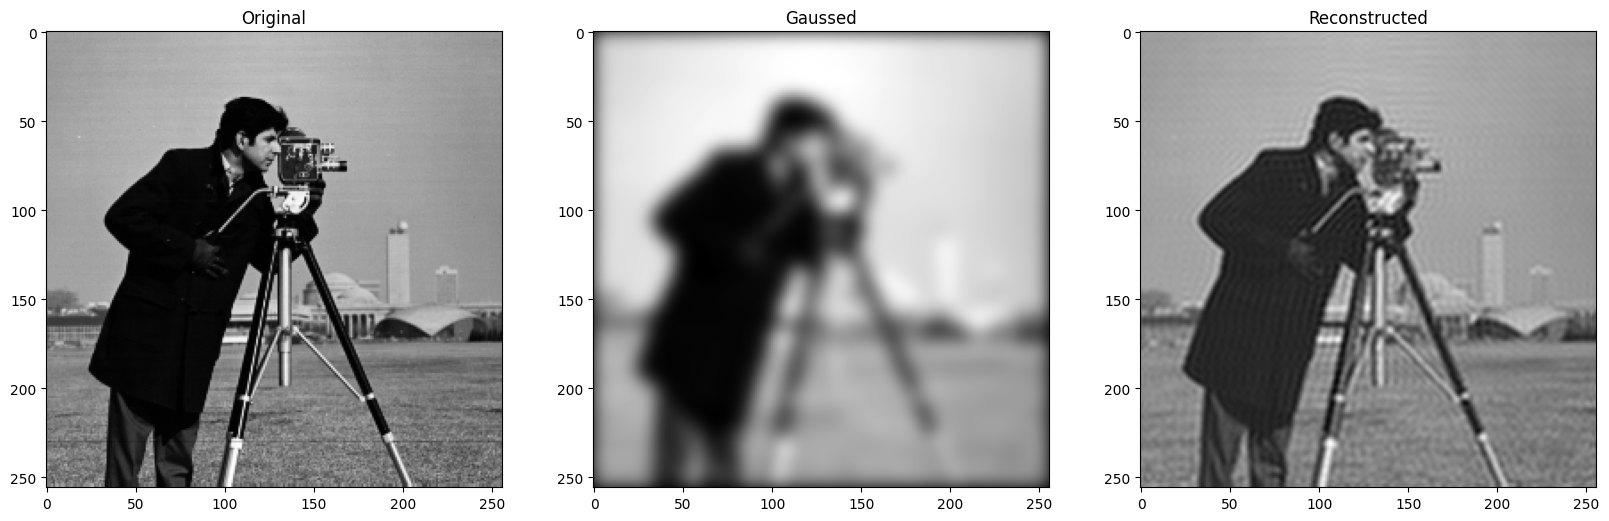

In [80]:
fig, axs = plt.subplots(1,3, figsize=(20,10))
axs[0].imshow(A, cmap='gray')
axs[0].set_title("Original")
axs[1].imshow(A_conv, cmap='gray')
axs[1].set_title("Gaussed")
A_rec = inverse_gauss_convolve_2D(A_conv, sigma, 1e-8)
axs[2].imshow(A_rec, cmap='gray')
_ = axs[2].set_title("Reconstructed")

## Бонус

Выберем 
$$
\tilde G(\Delta x, \Delta y) = C(\alpha) \exp\left(-\alpha\sqrt{\Delta x^2 + \Delta y^2}\right),
$$
где $C(\alpha)$ выбирается из $\ell_1$ нормировки массива (допускается найти $C(\alpha)$ численно).

1. **(60 б. баллов)** Разберитесь в том, что такое блочно теплицевы матрицы с теплицевыми блоками и блочно циркулятные матрицы с циркулянтными блоками (БТТБ и БЦЦБ, см., например, лекции прошлого года). С помощью вложения БТТБ в БЦЦБ матрицу $C$ реализуйте двумерную свертку с картинкой из предыдущей задачи и с фунцией $\tilde G$ вместо $G$. Постройте свертку для разных значений параметра $\alpha$ и опишите наблюдаемые эффекты.


2. **(40 б. баллов)** Используя $C$ из предыдущего бонусного пункта, дополните картинку нулями до подходящего размера, посчитайте свертку, а затем обратите ее с помощью применения $\delta$-псевдообратной. Требуемая сложность: $\mathcal{O}(mn \log mn)$ для $m\times n$ картинки. Постройте свертку для разных значений параметров $\alpha$ и $\delta$ и опишите наблюдаемые эффекты.

Найдем $\alpha$ аналитически:

$
\begin{aligned}
\iint\limits_{\mathbb{R}^2} C(\alpha) e^{-\alpha \sqrt{x^2 + y^2}} dx dy = 
C(\alpha) \iint\limits_{0\;0}^{2\pi\;\infty} e^{-\alpha r} r dr d\varphi =
\left. -C(\alpha)\dfrac{2\pi e^{-\alpha r}(\alpha r + 1)}{\alpha^2} \right\vert_{0}^{+\infty} = 
C(\alpha) \dfrac{2\pi}{\alpha^2} = 1 \implies
C(\alpha) = \dfrac{\alpha^2}{2\pi}.
\end{aligned}
$

Однако в задании будет использоваться численная нормировка

In [81]:
def form_G(alpha, size):
    if size % 2 != 1:  # we'll use odd-sized kernels
        size -= 1
    
    n0 = (size - 1)//2
    idx = np.arange(-n0, n0 + 1)
    I, J = np.meshgrid(idx, idx, indexing='ij')
    G = np.exp(-alpha * np.sqrt(I**2 + J**2))
    C_alpha = 1. / np.sum(G)
    
    return C_alpha * G

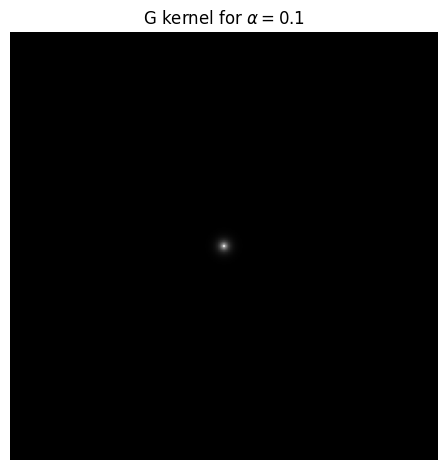

In [82]:
G_kernel = form_G(5e-1, 255)
plt.figure()
plt.title(fr"G kernel for $\alpha={1e-1}$")
plt.imshow(G_kernel, cmap='grey')
plt.axis(False)
plt.tight_layout()

In [83]:
def fft2_convolve(A, kernel):
    m, n = A.shape
    p, q = kernel.shape
    
    # zero-padding is applied before fft2, the size of fft2 is (m+p-1, n+q-1)
    A_pad_fft = np.fft.fft2(A, s=(m+p-1, n+q-1))
    kernel_pad_fft = np.fft.fft2(kernel, s=(m+p-1, n+q-1))
    
    result_pad = np.fft.ifft2(A_pad_fft * kernel_pad_fft).real
    result = result_pad[p//2:p//2 + m, q//2:q//2 + n]
    
    return result

Убедимся в правильности реализации, сравнив в `sp.signal.convolve`:

In [84]:
A_conv_G_fft = fft2_convolve(A, G_kernel)
A_conv_G_sp = signal.convolve(A, G_kernel, mode='same', method='fft')  # method='direct' is much slower due to large kernel size
print(f'{np.allclose(A_conv_G_fft, A_conv_G_sp) = }')

np.allclose(A_conv_G_fft, A_conv_G_sp) = True


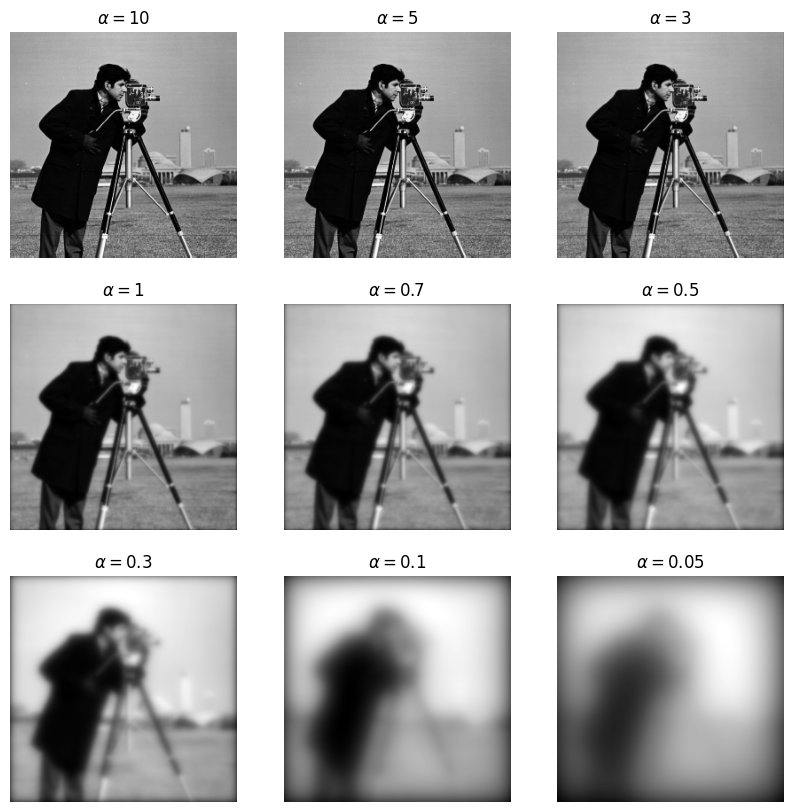

In [85]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
alphas = [10, 5, 3, 1, 0.7, 0.5, 0.3, 0.1, 0.05]
for ax, alpha in zip(axs, alphas):
    A_conv_G = fft2_convolve(A, form_G(alpha, A.shape[0]))
    ax.imshow(A_conv_G, cmap='gray')
    ax.set_title(rf'$\alpha={alpha}$')
    ax.set_axis_off()

Можно видеть, что при уменьшении $\alpha$ картинка становится более размытой, так как ядро свертки усредняет большее число соседних пикселей с существенно отличными от нуля коэффициентами. 

Реализуем обращение свертки, обнуляя малые значения по модулю ядра свертки в частотной области (с использованием соответствующего zero-padding'а). 

$
\begin{aligned}
\hat{X}^* = \begin{cases} \hat{Y} / \hat{K},\quad |\hat{K}| \geqslant \delta  \\  0,\quad \text{else},\end{cases}
\end{aligned}
$

где $\hat{K}$, $\hat{Y}$, $\hat{X}^*$ &mdash; ядро свертки, значение свертки изображения с ядром и оценка исходного изображения соответственно, все величины в частотной области, с необходимыми  zero-padding'ами.

Сложность алгоритма $O(mn \log(mn))$, так как основной вклад в асимптотическую сложность вносят два прямых и одно обратное двумерные БПФ.

In [86]:
def inverse_fft2_convolve(A_conv, kernel, tol):
    m, n = A_conv.shape
    p, q = kernel.shape
    
    A_conv_pad_fft = np.fft.fft2(A_conv, s=(m+p-1, n+q-1))
    kernel_pad_fft = np.fft.fft2(kernel, s=(m+p-1, n+q-1))
    
    mask = np.abs(kernel_pad_fft) >= tol  # zero-out small absolute values
    inverse_fft = np.zeros_like(A_conv_pad_fft)
    inverse_fft[mask] = A_conv_pad_fft[mask] / kernel_pad_fft[mask]
    
    A_deconv = np.fft.ifft2(inverse_fft).real
    
    return np.fft.ifftshift(A_deconv)[p//2: p//2 + m, q//2: q//2 + n]

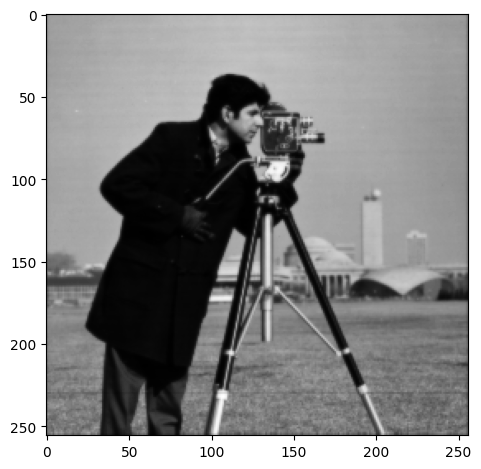

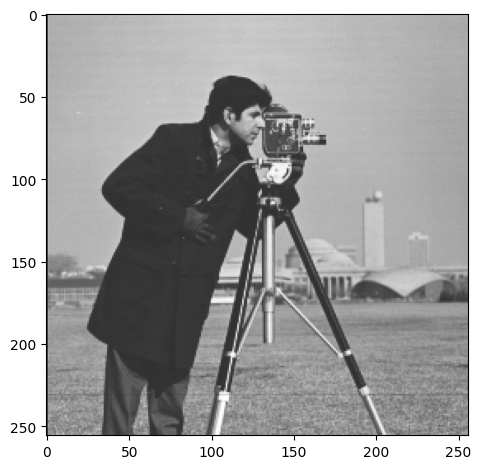

In [87]:
alpha = 2.
A_conv_G = fft2_convolve(A, form_G(alpha, A.shape[0]))
A_deconv = inverse_fft2_convolve(A_conv_G, form_G(alpha, A.shape[0]), 1e-2)
plt.figure()
plt.imshow(A_conv_G, cmap='gray')
plt.tight_layout()
plt.figure()
plt.imshow(A_deconv, cmap='gray')
plt.tight_layout()

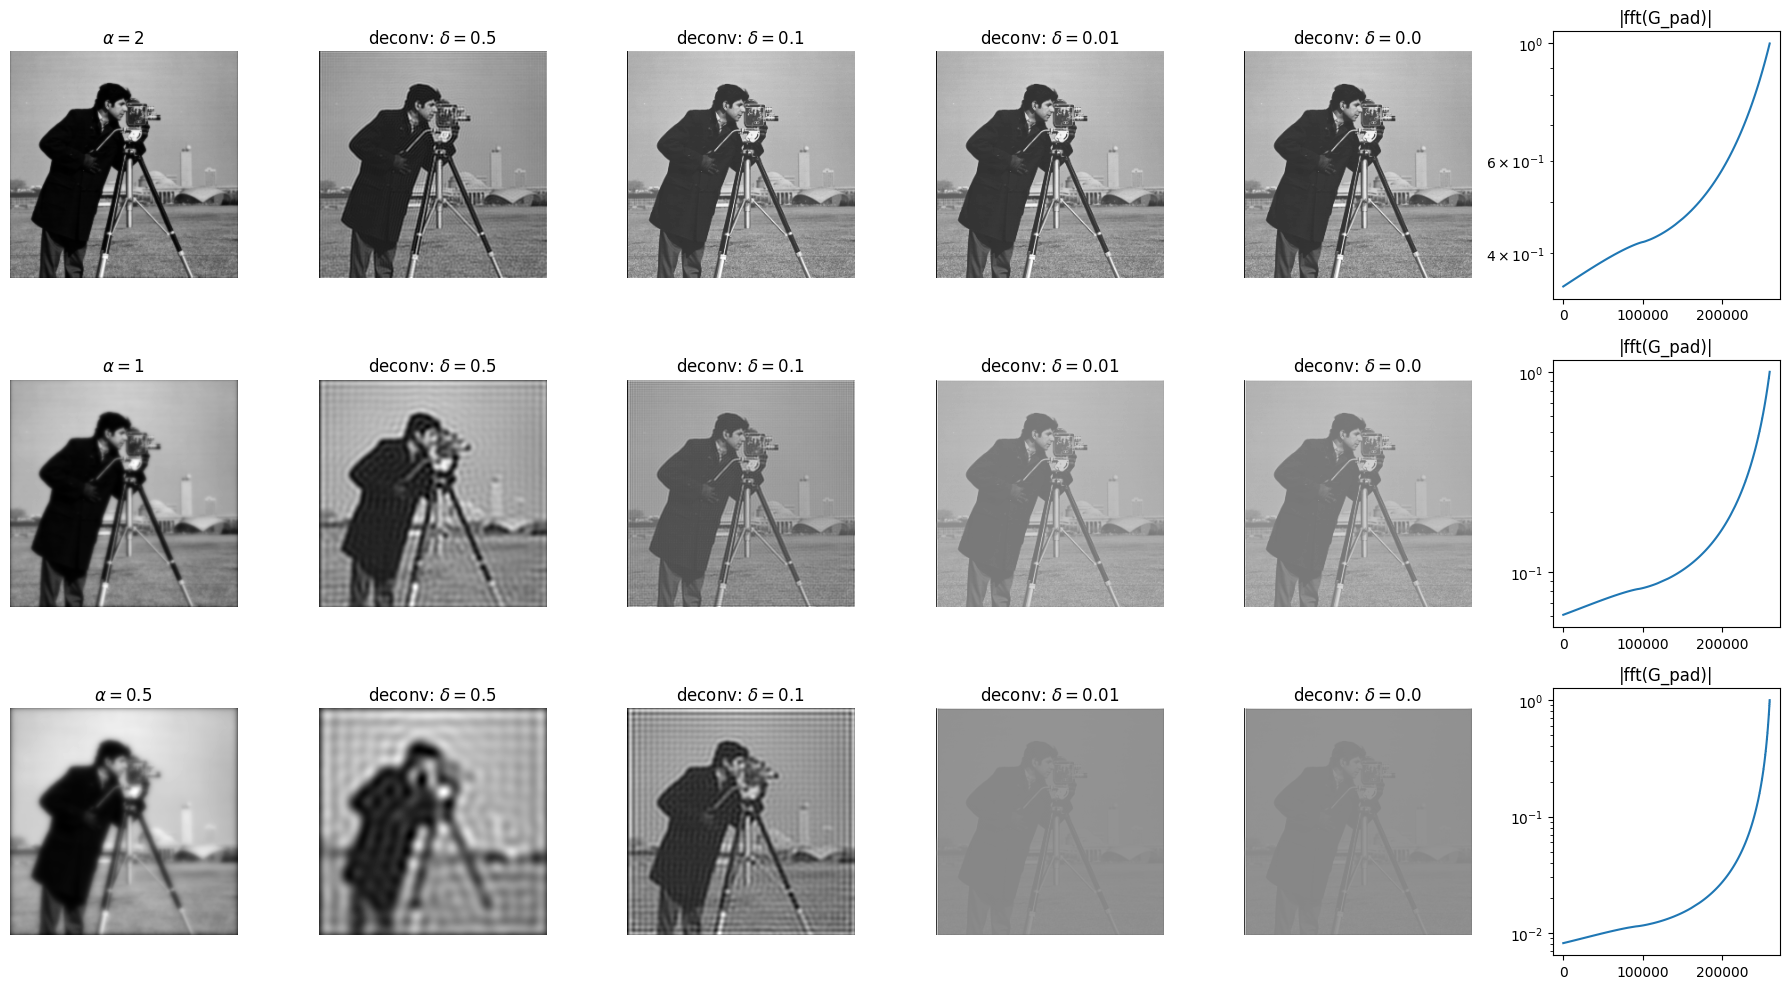

In [88]:
fig, axs = plt.subplots(3, 6, figsize=(18, 10))
alphas = [2, 1, 0.5]
deltas = [5e-1, 1e-1, 1e-2, 0.]
for ax_row, alpha in zip(axs, alphas):
    G = form_G(alpha, A.shape[0])
    A_conv_G = fft2_convolve(A, G)
    ax_row[0].imshow(A_conv_G, cmap='gray')
    ax_row[0].set_title(rf'$\alpha={alpha}$')
    ax_row[0].set_axis_off()
    for ax, delta in zip(ax_row[1:-1], deltas):
        A_deconv = inverse_fft2_convolve(A_conv_G, G, delta)
        ax.imshow(A_deconv, cmap='gray')
        ax.set_title(rf'deconv: $\delta={delta}$')
        ax.set_axis_off()
    
    ax_row[-1].set_title('|fft(G_pad)|')
    ax_row[-1].semilogy(np.sort(np.abs(np.fft.fft2(G, s=(G.shape[0]+A.shape[0]-1, G.shape[1]+A.shape[1]-1))).flatten()))

fig.tight_layout()

При более сильном сглаживании картинки (при меньших $\alpha$) обращение картинки менее качественное, видны сильные периодические артефакты, связанные с отбрасыванием большого числа малых сингулярных чисел. Для слабого сглаживагния (большие $\alpha$) удается получить более качественные изображения после обращения свертки. Из-за выбросов при обращении (больших по модулю значений пикселей) для некоторых $\delta$ картинки становятся более однотонными, так как уменьшается эффективный динамический диапазон значений пикселей, описывающих большую часть изображения. 